In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.storage as st

In [2]:
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)

In [3]:
%%time
storage = st.AnalysisStorage("mstis.nc")

CPU times: user 21.3 s, sys: 1.19 s, total: 22.5 s
Wall time: 22.5 s


In [4]:
len(storage.steps)

5001

In [5]:
mstis = storage.networks.load(0)
retis = mstis.sampling_transitions[0]
scheme = storage.schemes[0]

### Defining labels

Everything is actually done in terms of ensembles. We can map the ensembles to any labels. In our case, we use the initial replica ID associated with the ensemble. We use this as both the numeric and string label.

In [6]:
sset0 = storage.samplesets[0]
numeric_labels = {s.ensemble : s.replica for s in sset0}
string_labels = {s.ensemble : str(s.replica) for s in sset0}
numeric_to_string = {numeric_labels[e] : string_labels[e] for e in numeric_labels.keys()}

## Trace of ensemble visited by a replica

In the plot below, you'll see we set the labels on the axis as sset0[e].replica, so we use the replica ID associated with the ensemble in the first timestep.

In [7]:
%%time
trace_1 = paths.trace_ensembles_for_replica(0, storage.steps)

CPU times: user 53.5 ms, sys: 1.89 ms, total: 55.3 ms
Wall time: 60.7 ms


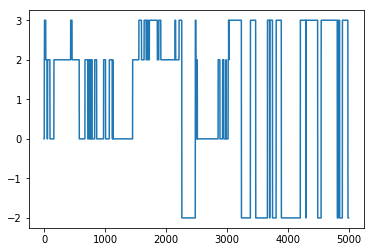

In [8]:
plt.plot([numeric_labels[e] for e in trace_1])

### Replica flow

In [9]:
%%time
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

CPU times: user 277 ms, sys: 3.56 ms, total: 280 ms
Wall time: 283 ms


In [10]:
%%time
flow = repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1],
                     included_ensembles=[retis.minus_ensemble]+retis.ensembles)
print(flow)

{<openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x10f30add0>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x113740790>: 0.27507047925896094, <openpathsampling.ensemble.TISEnsemble object at 0x1137407d0>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x113740f90>: 0.8509354254677127}
CPU times: user 4.96 ms, sys: 437 µs, total: 5.4 ms
Wall time: 5.26 ms


In [11]:
flow_num = {numeric_labels[k] : flow[k] for k in flow.keys()}
print(flow_num)

{8: 0.8509354254677127, 1: 0.0, -1: 1.0, 7: 0.27507047925896094}


In [12]:
sorted_vals = []
for k in sorted(flow_num.keys()):
    sorted_vals.append(flow_num[k])

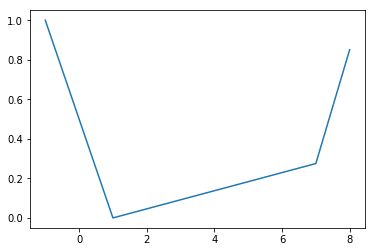

In [13]:
plt.plot(sorted(flow_num.keys()), sorted_vals)

### Trips

Now we calculate "up" trips, "down" trips, and round-trips.

In [14]:
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

No handlers could be found for logger "openpathsampling.analysis.replica_network"


{'down': [174, 404, 257, 3141, 548, 2718],
 'round': [1981, 2455, 687, 3159],
 'up': [1807, 2051, 139, 441, 189]}

### Transition matrix

The transition matrix is the (unsymmetrized) matrix of the transition probabilities. By default, it automatically sets its order from the Cuthill-McKee reverse ordering algorithm.

In [15]:
repx_net.transition_matrix().style
# .style has the effect that 0.0 is reported as 0 instead of 0.000000

,Out C minus,Out A minus,Out C 0,Out A 0,Out C 1,Out A 1,Out C 2,Out A 2,[UnionEnsemble],Out B 2,Out B 1,Out B 0,Out B minus
Out C minus,0,0,0.038674,0,0,0,0,0,0,0,0,0,0
Out A minus,0,0,0,0.0370955,0,0,0,0,0,0,0,0,0
Out C 0,0.038674,0,0,0,0.0205209,0,0,0,0,0,0,0,0
Out A 0,0,0.0370955,0,0,0,0.0205209,0,0,0,0,0,0,0
Out C 1,0,0,0.0205209,0,0,0,0.0489345,0,0,0,0,0,0
Out A 1,0,0,0,0.0205209,0,0,0,0.0402526,0,0,0,0,0
Out C 2,0,0,0,0,0.0489345,0,0,0,0.0165746,0,0,0,0
Out A 2,0,0,0,0,0,0.0402526,0,0,0.0189424,0,0,0,0
[UnionEnsemble],0,0,0,0,0,0,0.0165746,0.0189424,0,0.0205209,0,0,0
Out B 2,0,0,0,0,0,0,0,0,0.0205209,0,0.035517,0,0


If you would like to set a different order, that can be done by providing a list of the ensembles in whatever order you choose:

In [16]:
import numpy as np
perm = np.random.permutation(len(mstis.all_ensembles))
print(perm)

[ 8  1  0  5 12 11  9  2  7  3  4  6 10]


In [17]:
order = [mstis.all_ensembles[p] for p in perm]
repx_net.transition_matrix(index_order=order).style

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble],Out B minus,Out A minus,Out C minus
Out A 0,0,0.0205209,0,0,0,0,0,0,0,0,0,0.0370955,0
Out A 1,0.0205209,0,0.0402526,0,0,0,0,0,0,0,0,0,0
Out A 2,0,0.0402526,0,0,0,0,0,0,0,0.0189424,0,0,0
Out B 0,0,0,0,0,0.0213102,0,0,0,0,0,0.035517,0,0
Out B 1,0,0,0,0.0213102,0,0.035517,0,0,0,0,0,0,0
Out B 2,0,0,0,0,0.035517,0,0,0,0,0.0205209,0,0,0
Out C 0,0,0,0,0,0,0,0,0.0205209,0,0,0,0,0.038674
Out C 1,0,0,0,0,0,0,0.0205209,0,0.0489345,0,0,0,0
Out C 2,0,0,0,0,0,0,0,0.0489345,0,0.0165746,0,0,0
[UnionEnsemble],0,0,0.0189424,0,0,0.0205209,0,0,0.0165746,0,0,0,0


### Mixing matrix

Same as the transition matrix $T$, but $\frac{1}{2}(T+T^T)$.

In [18]:
repx_net.mixing_matrix().style

,Out C minus,Out A minus,Out C 0,Out A 0,Out C 1,Out A 1,Out C 2,Out A 2,[UnionEnsemble],Out B 2,Out B 1,Out B 0,Out B minus
Out C minus,0,0,0.038674,0,0,0,0,0,0,0,0,0,0
Out A minus,0,0,0,0.0370955,0,0,0,0,0,0,0,0,0
Out C 0,0.038674,0,0,0,0.0205209,0,0,0,0,0,0,0,0
Out A 0,0,0.0370955,0,0,0,0.0205209,0,0,0,0,0,0,0
Out C 1,0,0,0.0205209,0,0,0,0.0489345,0,0,0,0,0,0
Out A 1,0,0,0,0.0205209,0,0,0,0.0402526,0,0,0,0,0
Out C 2,0,0,0,0,0.0489345,0,0,0,0.0165746,0,0,0,0
Out A 2,0,0,0,0,0,0.0402526,0,0,0.0189424,0,0,0,0
[UnionEnsemble],0,0,0,0,0,0,0.0165746,0.0189424,0,0.0205209,0,0,0
Out B 2,0,0,0,0,0,0,0,0,0.0205209,0,0.035517,0,0


### Making a pretty picture

In [19]:
repxG = paths.ReplicaNetworkGraph(repx_net)

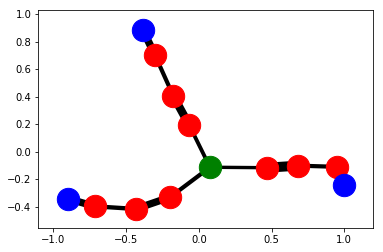

In [20]:
# draw('graphviz') gives better results, but requires pygraphviz
repxG.draw('spring')

Blue is a minus interface, red is a normal interface. The multiple state outer interface is green.